In [78]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
import torch

train_test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

In [79]:
def _create_mask(image_tensor: torch.Tensor, n_repeats: int = 8) -> tuple[torch.Tensor, torch.Tensor]:
    """Create a mask for the image.
    Start with random bit image and repeatedly blur with a filter of form [1/4, 1/2, 1/4]
    in both horizontal and vertical direction. Threshold the image to get a binary mask.

    Args:
        image_tensor (torch.Tensor): image tensor (1x28x28)

    Returns:
        tuple[torch.Tensor, torch.Tensor]: mask tensor, inverse of mask tensor
    """
    # Create random bit image
    mask = torch.randint(0, 2, image_tensor.shape).float()

    # Blur the image
    for _ in range(n_repeats):
        mask = F.conv2d(mask, torch.tensor([0.25, 0.5, 0.25]).view(1, 1, 3, 1), padding=(1, 0))
        mask = F.conv2d(mask, torch.tensor([0.25, 0.5, 0.25]).view(1, 1, 1, 3), padding=(0, 1))

    # Threshold the mask
    mask = (mask > 0.5).float()

    # Inverse of mask
    mask_inv = 1 - mask

    return mask, mask_inv

In [119]:
data_path = 'data'

positive_dataset = MNIST(
    root=data_path,
    train=True,
    download=True,
    transform=train_test_transforms,
)

negative_dataset = MNIST(
    root=data_path,
    train=True,
    download=True,
    transform=train_test_transforms,
)

test_dataset = MNIST(
    root=data_path,
    train=False,
    download=True,
    transform=train_test_transforms,
)

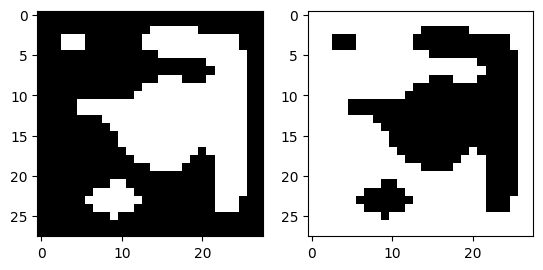

In [120]:
# Display the masks
import matplotlib.pyplot as plt
pos, neg = _create_mask(positive_dataset[0][0], n_repeats=8)
fig, ax = plt.subplots(1, 2)

ax[0].imshow(pos[0], cmap='gray')
ax[1].imshow(neg[0], cmap='gray')
plt.show()


In [121]:

original_images = negative_dataset.data.clone()
original_labels = negative_dataset.targets.clone()

In [132]:
import random
plot = False

# Create negative dataset
for i in range(len(negative_dataset)):

    # Create mask
    mask, mask_inv = _create_mask(original_images[i].unsqueeze(0))

    # Pick a random image from the dataset that has a different target label
    indices = original_labels != original_labels[i]
    indices = torch.nonzero(indices).squeeze()
    random_index = int(random.choice(indices))
    random_diff_digit  = original_images[random_index].unsqueeze(0)

    # Create new negative image
    negative_dataset.data[i] = (
        mask * original_images[i] + mask_inv * random_diff_digit[0]
    ) # TODO: stop changing in place

    # Display the image and the random_digit
    if plot:
        fig, ax = plt.subplots(1, 5)
        ax[0].imshow(original_images[i], cmap='gray') # original image])
        ax[1].imshow(mask[0], cmap='gray') # mask
        ax[2].imshow(mask_inv[0], cmap='gray') # inverse of mask
        ax[3].imshow(random_diff_digit[0], cmap='gray') # random digit
        ax[4].imshow(negative_dataset.data[i], cmap='gray') # new negative image

        plt.show()